### Test - Shadowgraphy Analysis - Power Spectrum

</b> Author:   </b>  Louis Evans     </br>
</b> Reviewer: </b>  Stefano Merlini

In [3]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

from matplotlib import patches
from scipy import ndimage

from lmfit.models import ExpressionModel

import sys
sys.path.insert(0, '../../')   # import path/to/synthpy

#import field_generator.gaussian1D as g1
#import field_generator.gaussian2D as g2
#import field_generator.gaussian3D as g3

import utils.power_spectrum as spectrum

import synthPy_restructured.beam as beam_initialiser
import synthPy_restructured.diagnostics as diag
import synthPy_restructured.domain as d
import synthPy_restructured.propagator as p
import synthPy_restructured.utils as utils

import importlib
importlib.reload(beam_initialiser)
importlib.reload(diag)
importlib.reload(d)
importlib.reload(p)
importlib.reload(utils)

ModuleNotFoundError: No module named 'diffrax'

### Import generated fields

In [ ]:
sh_15 = pickle.load(open("/rds/general/user/le322/home/synthPy/output/power_spec/1503_shadow.pkl", "rb"))[500:2001, 500:2001]
sh_20 = pickle.load(open("/rds/general/user/le322/home/synthPy/output/power_spec/2003_shadow.pkl", "rb"))[500:2001, 500:2001]
# sh_01 = pickle.load(open("/rds/general/user/le322/home/synthPy/output/power_spec/0103_shadow.pkl", "rb"))[500:2001, 500:2001]
sh_05 = pickle.load(open("/rds/general/user/le322/home/synthPy/output/power_spec/0503_shadow.pkl", "rb"))[500:2001, 500:2001]
sh_11 = pickle.load(open("/rds/general/user/le322/home/synthPy/output/power_spec/1103_shadow.pkl", "rb"))[500:2001, 500:2001]

generated_fields = [sh_15,sh_20,sh_05,sh_11]

FileNotFoundError: [Errno 2] No such file or directory: '/rds/general/user/le322/home/synthPy/output/power_spec/1503_shadow.pkl'

In [ ]:
for gen in generated_fields:
    plt.imshow(gen, clim = (0,10))
    plt.show()

### Calculate the power spectrum for each fields

[[Model]]
    <lmfit.ExpressionModel('c*x + a')>
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 31
    # variables        = 2
    chi-square         = 4.29469682
    reduced chi-square = 0.14809299
    Akaike info crit   = -57.2747935
    Bayesian info crit = -54.4068191
    R-squared          = 0.89971815
[[Variables]]
    c: -1.67277242 +/- 0.10370407 (6.20%) (init = -1.666667)
    a: -0.76192156 +/- 0.17194113 (22.57%) (init = 0.001)
[[Correlations]] (unreported correlations are < 0.100)
    C(c, a) = -0.9156
[[Model]]
    <lmfit.ExpressionModel('c*x + a')>
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 31
    # variables        = 2
    chi-square         = 7.50779369
    reduced chi-square = 0.25888944
    Akaike info crit   = -39.9594125
    Bayesian info crit = -37.0914381
    R-squared          = 0.93492534
[[Variables]]
    c: -2.79877006 +/- 0.13711523 (4.90%) (ini

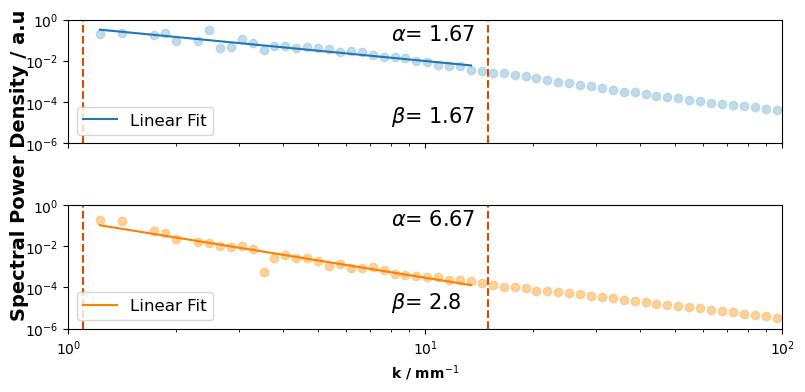

In [ ]:
import seaborn as sns
import matplotlib as mpl

_, wn_1503, ps_1503 = spectrum.radial_2Dspectrum(sh_15, 10, 10, smooth = False)
_, wn_2003, ps_2003 = spectrum.radial_2Dspectrum(sh_20, 10, 10, smooth = False)
_, wn_0503, ps_0503 = spectrum.radial_2Dspectrum(sh_05, 10, 10, smooth = False)
_, wn_1103, ps_1103 = spectrum.radial_2Dspectrum(sh_11, 10, 10, smooth = False)

#c1 = '#1C6758'   # dark green
#c2 = '#006e23'   # ciano
#c3 = '#6e0052'   # violet
#c4 = '#db4900'   # purple
#c5 = '#37e67d'   # light green

colors = sns.color_palette("Paired")
fig, axs = plt.subplots(2, 1, sharex = True, sharey = True, figsize = (8,4))

power = [5/3, 20/3]

def l_to_k(l):
    return 2 * np.pi / l

def analyse(sh, power, ax, colors):
    _, wn, ps_raw = spectrum.radial_2Dspectrum(sh, 10,10, smooth = False)

    ps = ps_raw[~(np.isnan(ps_raw))]
    wn = wn[~(np.isnan(ps_raw))]

    ps_scaled = ps/wn**2

    ps_norm = (ps_scaled - ps_scaled.min()) / (ps_scaled.max() + ps_scaled.min())

    ax.set_yscale('log')
    ax.set_xscale('log')

    # plt.vlines([2*np.pi/l_max], ps_norm.min(), ps_norm.max(), linestyle = 'dashed', label = '$k_{min}')

    ax.plot(wn , ps_norm, 'o', color = colors[0], alpha = 0.7)

    # hardcoded
    l_max = 2.5
    l_min = 0.1

    k_min, k_max = l_to_k(l_max), l_to_k(l_min)

    min_i = np.where(wn >= 1)[0][0]
    max_i = np.where(wn <= 15)[0][-1]

    mod = ExpressionModel('c*x + a')
    mod.make_params()

    mod.set_param_hint('a', value = 0.001)
    mod.set_param_hint('c', value = -5/3)

    res0 = mod.fit(np.array(np.log(ps_norm[min_i : max_i])), x = np.log(wn[min_i : max_i]), nan_policy='omit')

    print(res0.fit_report())

    ax.plot(wn[min_i: max_i], np.exp(res0.best_fit), label = 'Linear Fit', color = colors[1])

    ax.set_ylim(1e-6, 1)

    ax.tick_params(axis='y', which='minor', bottom=False)
    # ax.grid(which = 'both')

    grad = -res0.best_values['c']

    ax.annotate(r'$\alpha$' + f'= {np.round(power, 2)}', (8, 0.1), fontsize = 15)
    ax.annotate(r'$\beta$' + f'= {np.round((grad), 2)}', (8, 0.00001), fontsize = 15)

analyse(sh_05, 5/3,axs[0], [colors[0], colors[1]])
analyse(sh_20, 20/3,axs[1], [colors[6], colors[7]])

# plt.legend()
# axs[0].set_aspect(2/15)
# axs[1].set_aspect(2/15)

plt.xlim(1,100)
plt.xlabel('k / mm$^{-1}$', weight = 'bold')
fig.text(0.0, 0.58, 'Spectral Power Density / a.u', va='center', rotation='vertical', fontsize = 14,weight = 'bold')
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.5)
# axs[0].grid(which = 'both')
# axs[1].grid(which = 'both')
mpl.rcParams['legend.frameon'] = 'True'
axs[0].legend(fontsize = 12, loc = 'lower left')
axs[1].legend(fontsize = 12, loc = 'lower left')
# fig.get_layout_engine().set(w_pad=0 / 72, h_pad=0 / 72, hspace=0, wspace=0)
axs[0].vlines([1.1, 15], 1e-6, 1, linestyle = 'dashed', color = c4)
axs[1].vlines([1.1, 15], 1e-6, 1, linestyle = 'dashed', color = c4)

plt.savefig('FFT_shadow.png', dpi = 600)

### Relation between imposed slope value $\alpha$ and the computed value $\beta$

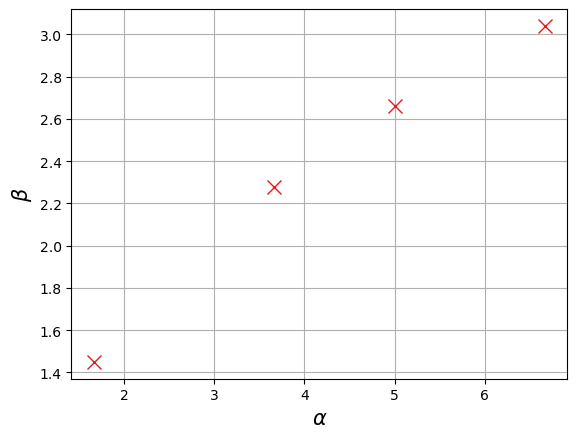

In [ ]:
plt.plot([5/3, 11/3, 15/3, 20/3], [1.45,2.28,2.66,3.04], 'x', markersize = 10, color = colors[5])

plt.xlabel(r'$\alpha$', weight = 'bold', fontsize = 15)
plt.ylabel(r'$\beta$', weight = 'bold', fontsize = 15)

plt.grid(zorder = 0)

plt.savefig('linearmaybe.png', dpi = 600)